## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/cardio/cardio_klek_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_klek_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_klek_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train = df_train_all['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

In [5]:
X_train.shape, y_train.shape

((8505, 4860), (8505,))

In [6]:
X_test.shape, y_test.shape

((2127, 4860), (2127,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,KRFP1,KRFP2,KRFP10,KRFP13,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,...,KRFP4820,KRFP4821,KRFP4823,KRFP4824,KRFP4826,KRFP4827,KRFP4829,KRFP4835,KRFP4843,KRFP4853
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1059,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1060,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1061,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
X_test

,KRFP1,KRFP2,KRFP10,KRFP13,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,...,KRFP4820,KRFP4821,KRFP4823,KRFP4824,KRFP4826,KRFP4827,KRFP4829,KRFP4835,KRFP4843,KRFP4853
0,1,1,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,1,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2123,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2124,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2125,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# write

with open('../../klek_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['cardio'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [10]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'cholesky', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 0.555021456015827
MSE: 0.5449859794584696
RMSE: 0.7382316570416563
R2 Square 0.3913682593342189 

Base model:
MAE: 0.5601056898283756
MSE: 0.5640336249821213
RMSE: 0.7510217207126045
R2 Square 0.3700961494312003 

Train set:
Tuned model:
MAE: 0.5125047902695612
MSE: 0.48214484642722455
RMSE: 0.6943665072763984
R2 Square 0.4690646578245651 

Base model:
MAE: 0.5281409502441643
MSE: 0.5193376056224193
RMSE: 0.7206508208712589
R2 Square 0.42810818908684545 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [13]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8, 10, 13],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 0.46950631328135667
MSE: 0.4297519539134038
RMSE: 0.6555546917789574
R2 Square 0.5200598003920438 

Base model:
MAE: 0.4721034551782033
MSE: 0.433189443906024
RMSE: 0.6581712876645592
R2 Square 0.51622086582017 

Train set:
Tuned model:
MAE: 0.3865425649261322
MSE: 0.26862549561948046
RMSE: 0.5182909372345618
R2 Square 0.7041910320298275 

Base model:
MAE: 0.38657979297699263
MSE: 0.269637222773907
RMSE: 0.5192660423847365
R2 Square 0.7030769234649343 



In [12]:
params = {'max_depth': 13, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train) 

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.46950631328135667
MSE: 0.4297519539134038
RMSE: 0.6555546917789574
R2 Square 0.5200598003920438 

Train set:
MAE: 0.3865425649261322
MSE: 0.26862549561948046
RMSE: 0.5182909372345618
R2 Square 0.7041910320298275 



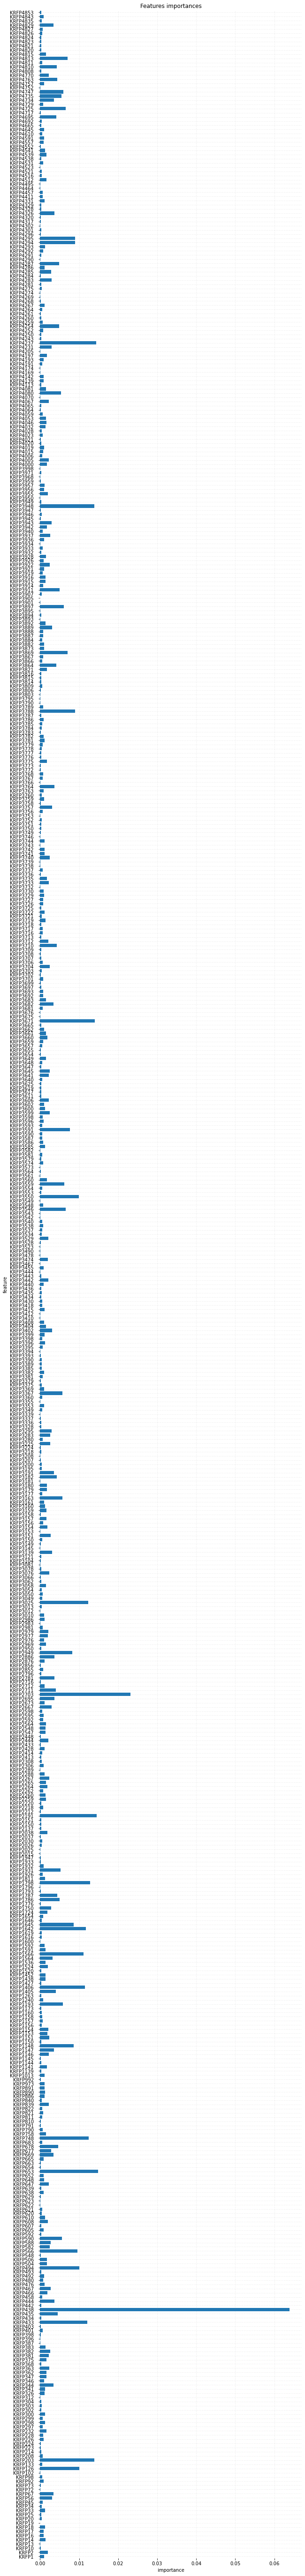

In [13]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [13]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [20]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [95, 120, 150],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.44704510057031827
MSE: 0.39409311051245854
RMSE: 0.6277683573679534
R2 Square 0.5598830339196499 

Base model:
MAE: 0.4400065586766657
MSE: 0.3840884661915444
RMSE: 0.6197487121338329
R2 Square 0.5710560627998251 

Train set:
Tuned model:
MAE: 0.36707335803990687
MSE: 0.2667181009987599
RMSE: 0.5164475781710666
R2 Square 0.7062914448479258 

Base model:
MAE: 0.32234913141624666
MSE: 0.1969697303036594
RMSE: 0.4438127198533852
R2 Square 0.7830979799288145 



In [14]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.44704510057031827
MSE: 0.39409311051245854
RMSE: 0.6277683573679534
R2 Square 0.5598830339196499 

Train set:
MAE: 0.36707335803990687
MSE: 0.2667181009987599
RMSE: 0.5164475781710666
R2 Square 0.7062914448479258 



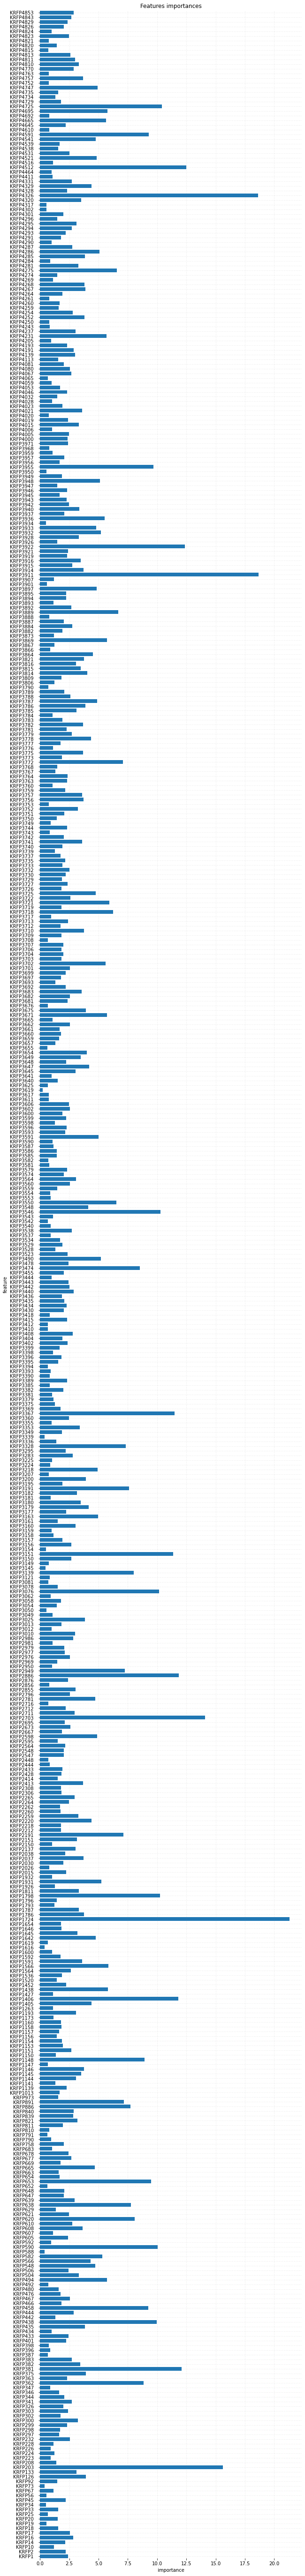

In [22]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883


## 5.4. LightGBM

Better results - third model.

In [28]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000],
    'min_child_samples': [85, 95,100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.4604194761257884
MSE: 0.4100830078837343
RMSE: 0.6403772387302147
R2 Square 0.5420257688945624 

Base model:
MAE: 0.45531599432267145
MSE: 0.3992231337908315
RMSE: 0.6318410668758652
R2 Square 0.5541539048865056 

Train set:
Tuned model:
MAE: 0.3889692573437675
MSE: 0.29534245326533065
RMSE: 0.5434541869056956
R2 Square 0.6747704602769627 

Base model:
MAE: 0.3743039145803564
MSE: 0.2677907093247468
RMSE: 0.517484984636991
R2 Square 0.7051102942605079 



In [16]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.46124942529924456
MSE: 0.41110005785144127
RMSE: 0.6411708491903241
R2 Square 0.5408899435421293 

Train set:
MAE: 0.3884746984222625
MSE: 0.2946018418999136
RMSE: 0.5427723665588675
R2 Square 0.6755860175760411 



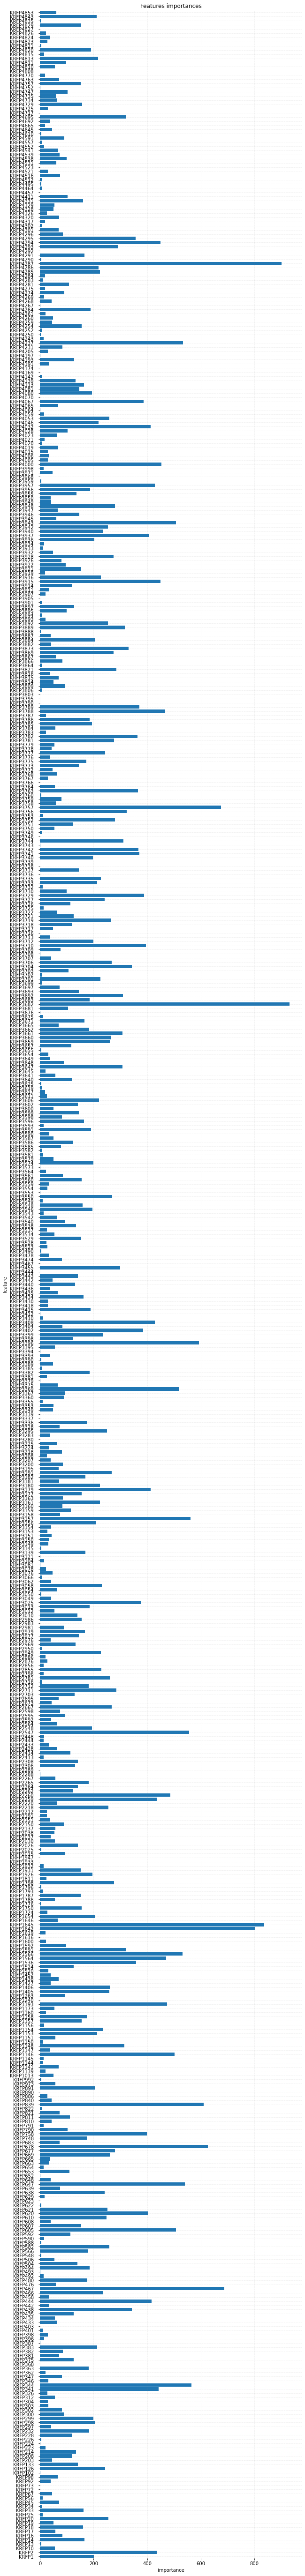

In [30]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [17]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [10]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 5, 10, 20],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20, 25],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 0.4549486936414924
MSE: 0.3968521436632693
RMSE: 0.6299620176354042
R2 Square 0.5568017892410233 

Base model:
MAE: 0.45531599487587576
MSE: 0.39922313354127165
RMSE: 0.6318410666783789
R2 Square 0.5541539051652101 

Train set:
Tuned model:
MAE: 0.3667545545783907
MSE: 0.2554604030420652
RMSE: 0.5054309082773483
R2 Square 0.7186883620005965 

Base model:
MAE: 0.37430391611886654
MSE: 0.2677907099980346
RMSE: 0.5174849852875295
R2 Square 0.7051102935190869 



In [18]:
params = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.4549486936414924
MSE: 0.3968521436632693
RMSE: 0.6299620176354042
R2 Square 0.5568017892410233 

Train set:
MAE: 0.3667545545783907
MSE: 0.2554604030420652
RMSE: 0.5054309082773483
R2 Square 0.7186883620005965 



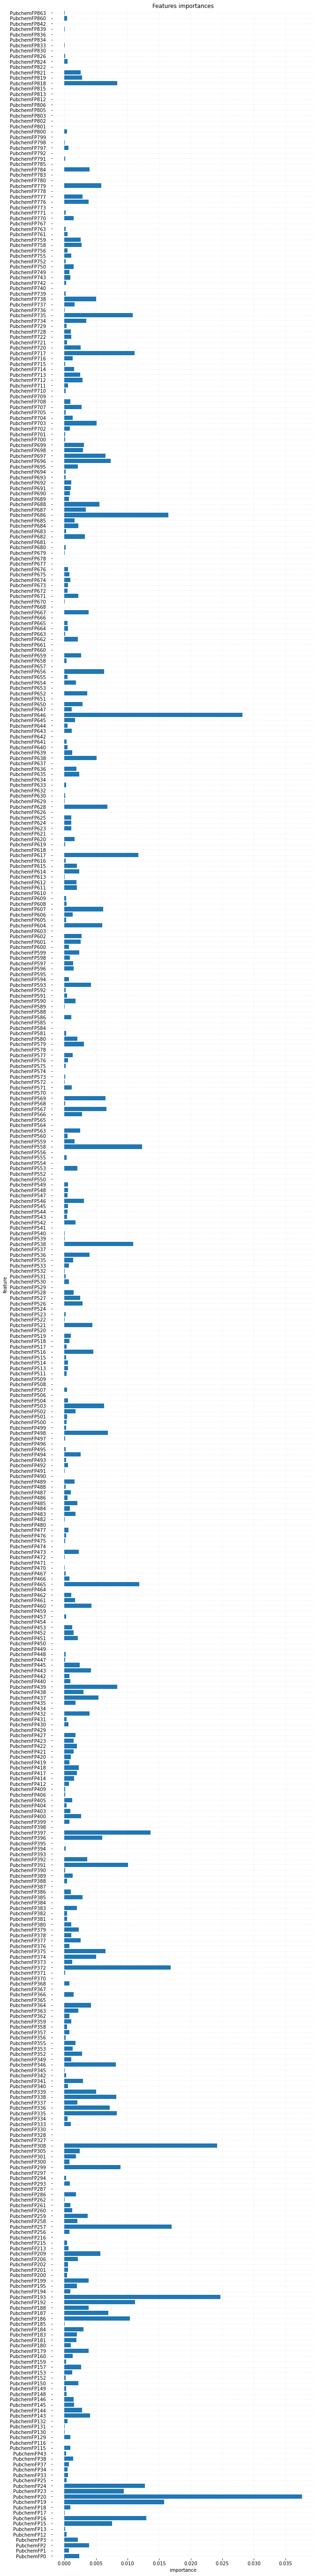

In [20]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [19]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890
4,HistGradient Boosting Regressor,0.454949,0.396852,0.629962,0.556802


## 5.6. Support Vector Regression

Better results - fifth model.

In [26]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1, 2.5, 3],
    'epsilon': [0.3, 0.5, 1, 2],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 2.5, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.45738611614623575
MSE: 0.3819245530437321
RMSE: 0.6180004474462232
R2 Square 0.5734726868515323 

Base model:
MAE: 0.4258157112450545
MSE: 0.400270286736186
RMSE: 0.6326691763759208
R2 Square 0.5529844610037333 

Train set:
Tuned model:
MAE: 0.37531089382189475
MSE: 0.23025302982839918
RMSE: 0.4798468816491352
R2 Square 0.7464465874005267 

Base model:
MAE: 0.31000274951727863
MSE: 0.26488852683873537
RMSE: 0.5146732233551066
R2 Square 0.7083061621883394 



In [20]:
params = {'C': 2.5, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.45738611614623575
MSE: 0.3819245530437321
RMSE: 0.6180004474462232
R2 Square 0.5734726868515323 

Train set:
MAE: 0.37531089382189475
MSE: 0.23025302982839918
RMSE: 0.4798468816491352
R2 Square 0.7464465874005267 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890
4,HistGradient Boosting Regressor,0.454949,0.396852,0.629962,0.556802
5,Support Vector Regression,0.457386,0.381925,0.618000,0.573473


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [22]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.20 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.20 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.44439668907087027
MSE: 0.3821396829755923
RMSE: 0.6181744761599206
R2 Square 0.5732324331389 

Train set:
MAE: 0.36431486109411787
MSE: 0.24415100849384105
RMSE: 0.49411639164658466
R2 Square 0.7311422071650802 



In [23]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890
4,HistGradient Boosting Regressor,0.454949,0.396852,0.629962,0.556802
5,Support Vector Regression,0.457386,0.381925,0.618000,0.573473
6,Averaging base models,0.444397,0.382140,0.618174,0.573232


### Averaging base models with Meta-model

In [24]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [25]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.015084,4.872197,4.948273,4.963800,4.936291
1,5.012168,4.872909,4.935163,4.932925,5.037767
2,4.930173,4.729577,4.734433,4.686390,4.780415
3,7.408999,6.646499,6.583363,7.099427,7.369464
4,4.814610,4.546826,4.521294,4.616562,4.500132
...,...,...,...,...,...
8500,5.108711,4.911373,4.940621,5.132627,5.021529
8501,5.011325,5.100851,5.105646,5.106270,5.244349
8502,5.062567,4.770235,4.821610,4.819040,4.907525
8503,4.982755,4.496162,4.484604,4.673260,4.531393


In [26]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.4317105333791646
MSE: 0.36503147573285916
RMSE: 0.6041783476200212
R2 Square 0.5923386089788036 

Train set:
MAE: 0.3222406071254179
MSE: 0.18291117200150722
RMSE: 0.4276811569399653
R2 Square 0.7985791896066889 



In [27]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890
4,HistGradient Boosting Regressor,0.454949,0.396852,0.629962,0.556802
5,Support Vector Regression,0.457386,0.381925,0.618000,0.573473
6,Averaging base models,0.444397,0.382140,0.618174,0.573232
7,Base models + Meta-model,0.431711,0.365031,0.604178,0.592339


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [28]:
params_rf = {'max_depth': 13, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10}    

params_svr = {'C': 2.5, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'} 

In [29]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])

test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = 6

kf = KFold(n_splits=n_splits,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx] 
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    test1 += model1.predict(X_test)/n_splits   
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))
    del model1

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    test2 += model2.predict(X_test)/n_splits
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    del model2
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    test3 += model3.predict(X_test)/n_splits
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    del model3
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    test4 += model4.predict(X_test)/n_splits
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    del model4
    
    
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    test5 += model5.predict(X_test)/n_splits
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    del model5
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.373138359348779
Model1 R2: 0.5613403287711833
Model2 MSE: 0.3412807932366574
Model2 R2: 0.5987919311775476
Model3 MSE: 0.3554594828638423
Model3 R2: 0.5821235314419342
Model4 MSE: 0.33600113341414245
Model4 R2: 0.6049986740221759
Model5 MSE: 0.3213282063871803
Model5 R2: 0.6222480968819559
Average MSE = 0.3454415950501203
Average R2 = 0.5939005124589594
-------------- fold 2 --------------
Model1 MSE: 0.4222834761334509
Model1 R2: 0.5476976616048186
Model2 MSE: 0.40385947876518946
Model2 R2: 0.5674313655341142
Model3 MSE: 0.41661115421272665
Model3 R2: 0.5537732118308545
Model4 MSE: 0.3858935884699398
Model4 R2: 0.586674396936377
Model5 MSE: 0.3946596291385726
Model5 R2: 0.5772852048012889
Average MSE = 0.4046614653439759
Average R2 = 0.5665723681414907
-------------- fold 3 --------------
Model1 MSE: 0.4316846487928736
Model1 R2: 0.54445004961456
Model2 MSE: 0.4026593119523393
Model2 R2: 0.5750800263686566
Model3 MSE: 0.42223966482636

In [30]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [31]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.027676,4.956154,4.955564,5.039017,5.021238
1,4.987393,4.944356,5.033169,5.112936,5.111096
2,4.974780,4.714878,4.648133,4.738882,4.724667
3,7.295333,6.431564,6.242016,6.769570,7.039762
4,4.853365,4.668934,4.615001,4.698955,4.859179
...,...,...,...,...,...
8500,5.162091,4.900567,5.003380,5.030274,4.910670
8501,4.978359,5.068175,5.020818,5.264151,5.290668
8502,5.183711,4.784410,4.937546,5.145705,4.911645
8503,4.998449,4.487197,4.453208,4.672767,4.335502


In [32]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.304072,5.451551,5.375161,5.393693,5.398490
1,5.366943,5.830842,5.891267,5.663803,5.915792
2,5.040739,5.069164,5.104074,5.160161,5.412112
3,5.705995,6.308552,6.244360,5.898165,6.155893
4,4.925394,4.508741,4.562386,4.691246,4.737677
...,...,...,...,...,...
2122,4.982810,4.703384,4.749504,4.743807,4.780022
2123,5.261044,4.951039,4.884052,4.971220,4.785638
2124,6.849229,6.168588,6.014015,6.592639,6.585937
2125,5.109363,5.487376,5.561714,5.366224,5.553343


In [33]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.43275236485288854
MSE: 0.3657948825202455
RMSE: 0.6048097903640826
R2 Square 0.5914860483270513 

Train set:
MAE: 0.42542759331657554
MSE: 0.3519234326246745
RMSE: 0.593231348315878
R2 Square 0.6124637865473104 



In [34]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.555021,0.544986,0.738232,0.391368
1,Random Forest Regressor,0.469506,0.429752,0.655555,0.520060
2,XGBoost,0.447045,0.394093,0.627768,0.559883
3,LightGBM,0.461249,0.411100,0.641171,0.540890
4,HistGradient Boosting Regressor,0.454949,0.396852,0.629962,0.556802
5,Support Vector Regression,0.457386,0.381925,0.618000,0.573473
6,Averaging base models,0.444397,0.382140,0.618174,0.573232
7,Base models + Meta-model,0.431711,0.365031,0.604178,0.592339
8,Base models + Meta-model + cv,0.432752,0.365795,0.604810,0.591486
